# Numerical Integrators for Ordinary and Partial Differential Equations (ODEs and PDEs)

In [17]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
import random
import tqdm

# **Deterministic Differential Equations**

## Forward (explicit) Euler method
Consider the first-order ODE
$$
\frac{{\rm d}y}{{\rm d}t} = f(t,y(t)) \hspace{2cm} (*)
$$

and its solution $y(t)$ at times $t = \{t_0,t_1,\dots,t_n\}$. Taylor-expanding $y$ around time $t_k$ using a small time step $h$, we obtain

$$
y(t_{k+1}) = y(t_k+h) = y(t_k) + hy'(t_k) + \frac{h^2}{2}y''(t_k) + \dots
$$

Trucating, we obtain
$$
y(t_{k+1}) = y(t_k) + hy'(t_k) + O(h^2).
$$

And using $y'(t) = f(t,y(t))$, we obtain the forward Euler scheme:

$$
y^{k+1} \leftarrow y^k + hf(t_k,y^k) \hspace{2cm} \text{(forward Euler)}
$$

where $y^k$ denotes the numerically computed value of $y(t_k)$.

We can interpret forward Euler as a linear finite-difference approximation of the derivative:

$$
y'(t_k) \approx \frac{y(t_{k+1}) - y(t_k)}{h}
$$

(where $t_{k+1} := t_k + h$) and we would find that substituting this into $(*)$ would yield the same formula for $y^{k+1}$ as before.

# Backward (implicit) Euler method

If we instead Taylor expand around the _next_ time $t_{k+1}$,

$$
y(t_k) = y(t_{k+1}-h) = y(t_{k+1}) - hy'(t_{k+1}) + \dots
$$

and again make a linear approximation, we obtain

$$
y^{k+1} \leftarrow y^k + hf(t_{k+1}, y^{k+1}).
$$

Compared to forward Euler, we are linearizing around $t_{k+1}$ instead of $t_k$. Note that $y^{k+1}$ appears on both sides of the equation, so compared to forward Euler it can be more involved to solve for $y^{k+1}$.

## (1) Euler Methods for a 1st-order Linear ODE
Consider the ODE
$$
\dot{q} + rq = f(t) \hspace{1cm} (*)
$$

where $\dot{q}(t) := \frac{{\rm d} q(t)}{{\rm d}t}$. In this equation, we will assume $f(t)$ has the form

$$
f(t) = a \sin t.
$$

`integrateForwardEuler()` and `integrateBackwardEuler()` implement the forward and backward Euler methods discussed above. These integrators will be used to simulate the system $(*)$ from time 0 to time $T$. To simplify things, we've discretized $[0,T]$ into $N$ time intervals of equal length, specified by timepoints $\{t_k\}_{k=0}^N$ where $t_k = kh$ and $h:=T/N$. At each time $t_k$, we need to compute $q^{k+1}$.

In [18]:
class SignalResponse():

  def __init__(self, q, r=1.0, a=1.0):
    self.r = r
    self.a = a
    self.q = q

  def integrateForwardEuler(self, h, k):
    self.q += h*(self.a*np.sin(k*h)-(self.r*self.q))
    return self.q

  def integrateBackwardEuler(self, h, k):
    self.q = (self.q + (h*self.a*np.sin(k*h + h)))/((h*self.r)+1)
    return self.q

Run the following cell to plot the results of using forward/backward Euler to integrate the ODE, vs. the analytical solution, for a particular initial condition $q(0)$.

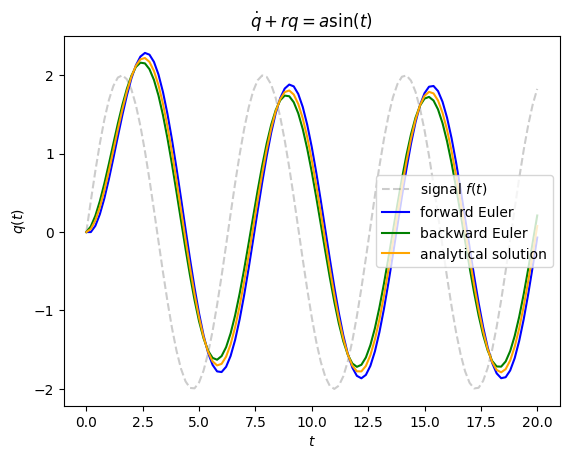

In [19]:
def SR(q0, r, a, t):
  C = q0 + a/(1.0+r*r)
  return C * np.exp(-r*t) + (a*(r*np.sin(t)-np.cos(t)))/(1.0+r*r)

N = 100
T = 20.0
h = T/N
times = np.linspace(0, T, N+1)
a = 2.0
r = 0.5
q0 = 0.0 # initial condition
forward = [q0]
backward = [q0]
signalResponse = SignalResponse(q0, r, a)
forward += [signalResponse.integrateForwardEuler(h, k) for k in range(N)]
signalResponse = SignalResponse(q0, r, a)
backward += [signalResponse.integrateBackwardEuler(h, k) for k in range(N)]


plt.plot(times, [a*np.sin(h*k) for k in range(N+1)], label='signal $f(t)$', color='black', linestyle='dashed', alpha=0.2)
plt.plot(times, forward, label='forward Euler', color='blue')
plt.plot(times, backward, label='backward Euler', color='green')
plt.plot(times, [SR(q0, r, a, h*k) for k in range(N+1)], label='analytical solution', color='orange')

plt.legend()
plt.xlabel("$t$")
plt.ylabel("$q(t)$")
plt.title("$\dot{q} + rq = a\sin(t)$")
plt.show()

# Euler Methods for a 2nd-order Linear ODE

Newton's second law of motion, which expresses the displacement $q(t)$ at time $t$ of an object with mass $m$ subject to a force $F$, is an example of a 2nd-order ODE:

$$
m\ddot{q}(t) = F(q(t)) \hspace{2cm} (*)
$$

where $\ddot{q}(t) := \frac{{\rm d}^2 q(t)}{{\rm d}t^2}$.

For now, let $F = g - \alpha \dot{q}(t)$, where $g=-9.81\ m/s^2$ represents gravitational acceleration, and $\alpha$ is a drag coefficient with units $s^{-1}$. The equation $(*)$ becomes a linear ODE, since the entire equation is linear in $q$ and its derivatives. This ODE can be solved analytically in this case, but let's again use the forward and backward Euler methods to numerically integrate this ODE.

We can rewrite the ODE as two coupled first-order equations:

$$
\begin{align*}
  \dot{q} &= v \\
  \dot{v} &= \frac{1}{m}\left(g - \alpha v\right).
\end{align*}
$$

The cells below implement different integrators to simulate this system from time 0 to time $T$. Assume we've discretized $[0,T]$ into $N$ time intervals of equal length, specified by timepoints $\{t_k\}_{k=0}^N$ where $t_k = kh$ and $h:=T/N$. At each time $t_k$, we need compute $q^{k+1} := q(t_{k+1})$ and $v^{k+1} := v(t_{k+1})$.

In [20]:
class ProjectileMotion():

  def __init__(self, q, v, m=1.0, alpha=1.0, g=-9.81):
    self.q = q
    self.v = v
    self.m = m
    self.g = g
    self.alpha = alpha

  def integrateForwardEuler(self, h):
    self.q += h*self.v
    self.v += h*(self.g - (self.alpha*self.v))/self.m
    return self.q

  def integrateBackwardEuler(self, h):
    '''We solve for the following system of equations:
       q^{k+1} = q^k + hv^{k+1}
       v^{k+1} = v^k + (h/m)*(g-alpha*v{k+1})'''
    f = lambda x : [x[0] - (h*x[1])-self.q , x[1]*(1+(h*self.alpha)/self.m) - (h*self.g/self.m) - self.v]
    res = sp.optimize.fsolve(f,[0,0])
    self.q = res[0]
    self.v = res[1]
    return self.q

Run the following cell to compare the Euler methods with the analytical solution. The initial conditions $q(0)$ and $v(0)$ have already been provided; the equation $(*)$ models the projectile motion of a particle with this initial position and vertical velocity, subject to the influence of gravity and drag.

Note that the following cell also plots the result of 4th-order Runge Kutta, a popular numerical integration scheme.

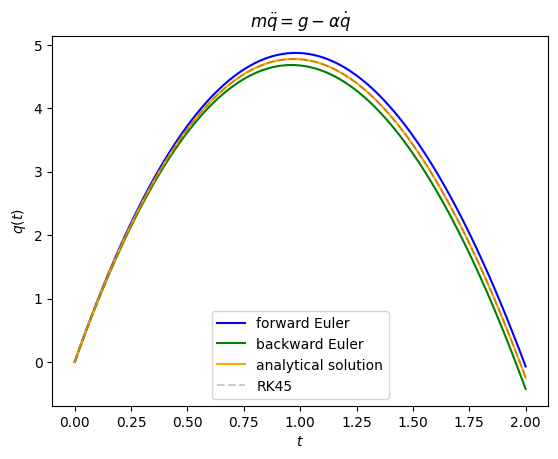

In [21]:
def PM(q0, v0, m, alpha, g, t):
  C1 = g/alpha - v0
  C2 = q0 + (m*v0)/alpha - (g*m)/(alpha*alpha)
  return (g * t + np.exp(-t*alpha/m)*m*C1)/alpha + C2

N = 100
T = 2.0
h = T/N
times = np.linspace(0, T, N+1)
alpha = 0.1
m = 1.0
g = -9.81
q0 = 0.0
v0 = 10.0
forward = [q0]
backward = [q0]
projMotion = ProjectileMotion(q0, v0, m, alpha, g)
forward += [projMotion.integrateForwardEuler(h) for k in range(N)]
projMotion = ProjectileMotion(q0, v0, m, alpha, g)
backward += [projMotion.integrateBackwardEuler(h) for k in range(N)]

def fun(t, Q):
    return [Q[1], (g - alpha*Q[1])/m]
spInt = sp.integrate.RK45(fun, t0=0, y0=[q0, v0], t_bound=T, max_step=h, rtol=1, atol=1)
RK = np.empty(N+1)
RK[0] = q0
for k in range(N):
  spInt.step()
  RK[k+1] = spInt.y[0]

plt.plot(times, forward, label='forward Euler', color='blue')
plt.plot(times, backward, label='backward Euler', color='green')
plt.plot(times, [PM(q0, v0, m, alpha, g, h*k) for k in range(N+1)], label='analytical solution', color='orange')
plt.plot(times, RK, label='RK45', color='black', linestyle='dashed', alpha=0.2)

plt.legend()
plt.xlabel("$t$")
plt.ylabel("$q(t)$")
plt.title(r'$m\ddot{q} = g-\alpha \dot{q}$')
plt.show()

# More PDEs

In this part, we'll explore an example of [_curve-shortening flow_](https://en.wikipedia.org/wiki/Curve-shortening_flow), which involves heat diffusion in 1D. Let $\gamma(s,t)$ be a plane curve parameterized by an arclength parameter $s$ and time $t$. The time evolution of $\gamma$ according to curve-shortening flow is given by

$$
\frac{\partial \gamma}{\partial t} = -\kappa(s)n(s) = \frac{\partial^2\gamma}{\partial s^2}
$$

where $\kappa$ is the curvature of $\gamma$ and $n$ is the outward-pointing normal. For curves which are not arclength-parameterized, this flow represented by the 1D heat equation

$$
\frac{\partial \gamma}{\partial t} = \rho(s)\frac{\partial^2\gamma}{\partial s^2}  \hspace{2cm}  (*)
$$

where $\rho$ represents the "density" of the curve.

Because $\gamma$ depends on two parameters $s$ and $t$, to numerically integrate this PDE we must discretize in both space and time. Assume we have discretized the time interval $[0,T]$ into $N$ equally-sized intervals, specified by timepoints $\{t_0,t_1,\dots,t_N\}$; assume also that we have discretized space $[a,b]$ into $M$ equal-sized intervals specified by $\{s_0=a,s_1,\dots,s_M=b\}$.

To discretize in time, we will use the forward (explicit) Euler method. In particular, we will approximate the l.h.s. of $(*)$ with the finite difference

$$
\frac{\gamma^{k+1}_i - \gamma^k_i}{\Delta t} \hspace{2cm} (1)
$$

where $\Delta t := t_{k+1}-t_k$ is a fixed timestep, and $\gamma^k_i$ represents the numerically-determined position of $\gamma(s_i)$ at time $t_k$. We assume that the curve $C(s) = (s, \gamma(s)) \subset\mathbb{R}^2$, so $\gamma(s)$ simply represents a height over the $x$-axis.

To discretize in space, we will take a second-order finite difference,

$$
\frac{\partial^2\gamma(s_i,t_k)}{\partial s^2} \approx \frac{1}{\Delta s}\left(\frac{\gamma^k_{i+1} - \gamma^k_i}{\Delta s} - \frac{\gamma^k_i-\gamma^k_{i-1}}{\Delta s}\right) = \frac{\gamma^k_{i+1} - 2\gamma^k_i + \gamma^k_{i-1}}{(\Delta s)^2} \hspace{2cm} (2)
$$

where $\Delta s := s_{i+1}-s_i$ is a fixed length. (Many other finite-differencing schemes for PDEs exist. For example, the [Crank-Nicolson method](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) is often used to integrate diffusion equations, [Lax-Wendroff](https://en.wikipedia.org/wiki/Lax%E2%80%93Wendroff_method) for hyperbolic equations, etc. In addition, while we have only mentioned finite-difference methods so far, other types of numerical integration methods also exist, such as [finite elements](https://en.wikipedia.org/wiki/Finite_element_method).)

For simplicity, we will assume that the density $\rho=1$ everywhere (effectively always treating the curve as arclength-parameterized, even though it may not be.)

Putting together $(1)$ and $(2)$ and discretizing explicitly in time, we obtain the simple update rule

$$
\begin{align*}
&\frac{\gamma^{k+1}_i - \gamma^k_i}{\Delta t} = \frac{\gamma^k_{i+1} - 2\gamma^k_i + \gamma^k_{i-1}}{(\Delta s)^2} \\
\Rightarrow\ &\gamma^{k+1}_i = \gamma^k_i + \frac{\Delta t}{(\Delta s)^2}\left(\gamma^k_{i+1} - 2\gamma^k_i + \gamma^k_{i-1}\right). \hspace{2cm} (\star)
\end{align*}
$$

In this example, let $\gamma$ have the initial condition

$$
\gamma(s, 0) = \cos(s) + \sin(2s)
$$

and be defined on the periodic interval $[-2\pi,2\pi]$ (meaning $2\pi$ is identified with $-2\pi$), so we have only $M$ spatial points $\{s_0, \dots,s_{M-1}\}$ (meaning $\gamma$ only has $M$ distinct vertices $\{\gamma(s_0),\dots,\gamma(s_{M-1})\}$.) In particular, $\gamma(s_i) = \gamma(s_{i\ \%\ M})$ if $i\notin[0,M-1]$, where $\%$ is Python's modulo operator.

In [22]:
class CurvatureFlow():

  def __init__(self, T=0.3, N=300, M=512):
    self.T = T
    self.M = M
    self.N = N
    self.L = 4.0*np.pi
    self.dt = self.T/self.N
    self.ds = self.L/self.M
    # Define initial curve, which has M vertices and M segments.
    self.gamma = np.array([np.cos(s) + np.sin(2.0*s) for s in np.linspace(-2.0*np.pi, 2.0*np.pi, self.M, endpoint=False)])

  def integrate(self):
    newGamma = []
    for i in range(self.M):
      newGamma.append(self.gamma[i] + (self.dt/(self.ds**2))*(self.gamma[(i+1) % self.M]-(2*self.gamma[i]) + self.gamma[(i-1)%self.M]))

    return np.array(newGamma)

  def integrateAndUpdate(self):
    self.gamma = self.integrate()
    return self.gamma

Run following cell to play an animation of the curve, evolving in time according to your integrator. The cell below will show two animations, the first using a smaller timestep, the second using a larger timestep. Using explicit Euler to discretize time will be unstable for the larger timestep! The necessary condition for stability of finite-difference schemes for PDEs is called the [_CFL condition_](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition). In this particular example, the CFL condition requires that $\frac{\Delta t}{(\Delta s)^2}\leq \frac{1}{2}$.

In [23]:
N0 = 160
factor = 2
N1 = N0/factor
M = 64
T = 3.0

explicitSmall = CurvatureFlow(T, N0, M)
explicitLarge = CurvatureFlow(T, N1, M)
x = np.linspace(-2.0*np.pi, 2.0*np.pi, M+1, endpoint=True)

titles = [r'$\Delta t$ = %0.3f' %(T/N0), r'$\Delta t$ = %0.3f' %(T/N1)]
fig, axs = plt.subplots(1,2,figsize=(12,5))
for i in range(2):
  axs[i].set_xlim((-2.0*np.pi, 2.0*np.pi))
  axs[i].set_ylim((-2, 2))
  axs[i].set_title(titles[i])
  axs[i].set_ylabel(r'$\gamma(s)$')
  axs[i].set_xlabel(r'$s$')
line1, = axs[0].plot([], [], lw=2)
line2, = axs[1].plot([], [], lw=2)
lines = [line1, line2]

def init():
  y = explicitSmall.gamma
  y = np.append(y, y[0])
  for i in range(len(lines)):
    lines[i].set_data(x, y)
  return lines

def animate(i):
  # explicit Euler, smaller timestep
  y_es = explicitSmall.integrateAndUpdate()
  y_es = np.append(y_es, y_es[0])
  lines[0].set_data(x, y_es)
  # explicit Euler, larger timestep
  if (i%factor!=0):
    y_eu = explicitLarge.integrateAndUpdate()
    y_eu = np.append(y_eu, y_eu[0])
    lines[1].set_data(x, y_eu)
  return lines

fig.tight_layout()
rc('animation', html='html5')
anim = animation.FuncAnimation(fig, animate, init_func=init, interval=60, frames=tqdm.tqdm(range(N0),position=0,leave=True), blit=True, repeat=False)
plt.close()

anim

  2%|▎         | 4/160 [00:00<00:27,  5.59it/s]

 99%|█████████▉| 159/160 [00:21<00:00,  7.48it/s]


# **Stochastic Differential Equations**

Now let's explore stochastic (partial) differential equations.


# Heat Diffusion in 2D

This section will explore heat diffusion. In particular, we will consider _equilibrium solutions_ of heat diffusion on a domain $\Omega$, which can be described by the following time-independent PDE:

$$
\begin{align*}
&\Delta u = 0 \hspace{1cm} \text{(Laplace equation)} &\text{on $\Omega$} \\
&\text{subject to boundary conditions on $\partial\Omega$.}
\end{align*}
$$

Given a set of boundary conditions which, say, prescribe the amount of heat at the boundary $\partial\Omega$, the solution $u(x)$ describes the amount of heat at a spatial location $x\in\Omega$ when the system has reached equilibrium.

To make things more interesting, we will consider the following instance of heat diffusion,

$$
\begin{align*}
\Delta u - \vec{\omega}\cdot\nabla u &= -f &\text{on $\Omega$} \\
u(x) &= g(x) &\text{on $\partial\Omega$}
\end{align*}
\hspace{2cm}
(1)
$$

where $\vec{\omega}(x)$ is a _transport coefficient_ describing the drift $u(x)$ experiences, $f(x)$ is a _source term_ representing a source of heat, and $g(x)$ are _Dirichlet boundary conditions_ prescribing the value of $u(x)$ on the boundary $\partial\Omega$ of the domain. See the code cell below for a visual representation for all these parameters.

## Feynman-Kac: Using SDEs to understand deterministic PDEs
Sometimes we may choose to solve an SDE even though we could also describe the phenomenon of interest via a deterministic PDE.

The Feynman-Kac formula gives the solution to a PDE as a stochastic process. Sometimes, zooming in to the "micro level" -- and describing the solution in terms of random walks -- can give us additional computational flexibility. Applying the Feynman-Kac formula to $(1)$ tells us that the solution $u(x)$ can be expressed as an expected value

$$
\begin{align*}
u(x) = \mathbb{E}\left[\int_0^\tau f(X_t){\rm d}t + g(X_\tau) \right]
\end{align*}
$$

where $X_t$ is the _diffusion process_ described by
$$
{\rm d}X_t = -\vec{\omega}(X_t){\rm d}t + {\rm d}W_t \hspace{2cm} (2)
$$

where $W_t$ is a Wiener process (a.k.a. Brownian motion) and $\tau$ is the time when $W_t$ first hits the domain boundary $\partial\Omega$.

We can solve the SDE in (2) using the Euler-Maruyama method. The Euler-Maruyama method is a standard technique for integrating SDEs, and is analogous to the explicit Euler method you implemented in the ODE case.

$$
X_{k+1} = X_k - \vec{\omega}(X_k)\Delta t + \Delta W_k \hspace{2cm} (3)
$$

where $\Delta W_k := W_{k+1}-W_k$, and the $\Delta W_k$ are i.i.d. normal random variables with expected value zero and variance $\Delta t := t_{k+1}-t_k$. (Note here that "$\Delta$" is being used to mean a difference operator, not the Laplacian $\nabla^2$.) This yields the following algorithm for solving for $u(x)$:

* Use the Markov chain in $(3)$ to simulate a random walk starting at $X_0=x$. Approximate $\int_0^\tau f(X_t){\rm d}t$ with quadrature, for example using the left rectangle rule $\hat{F}_i = \Delta t\sum_{k=1}^{K} {f(X_{k-1})}$ where $K$ is the number of steps the random walker takes until it exits the domain.
* When $X_k$ exits the domain $\Omega$, clamp to the closest point on $x'\in\partial\Omega$. Compute a single estimate $\hat{I}_i := \hat{F}_i + g(x')$.
* Repeat for $N$ walks starting from $x$, returning the estimate $\frac{1}{N}\sum_{i=1}^N \hat{I}_i$.


## Fokker-Planck: Using deterministic PDEs to understand stochastic PDEs
The Fokker-Planck equation (also known as _Kolmogorov forward equation_) complements the perspective provided by the Feynman-Kac formula. The Fokker-Planck equation is a PDE that describes the evolution in time of a probability density function. In short, we may be interested in modeling a phenomenon that can naturally be expressed as a stochastic process -- but rather than use stochastic processes to model the phenomenon, we may choose to zoom out to the "macro level" and model its behavior in aggregate via a PDF that gives a statistical description of the phenomenon. For example, people may be interested in the macroscopic state of the system, and do not want to reason about individual particles -- simulating a system at the latter level of detail can yield an computationally intractable solution for certain types of problems.

The Fokker-Planck equation for the SDE in (2) is Equation (1). The example below implements a finite-difference scheme for solving the PDE in $(1)$, similar to the 1D finite-difference scheme you implemented in the previous example. We will consider a square domain $\Omega\subset\mathbb{R}^2$, and discretize $\Omega$ with a regular grid with equal spacings $h = \Delta x=\Delta y$. In particular, the $x$-axis (resp. $y$-axis) of the square $\Omega = [0,L]^2$ is partitioned into $M$ vertices $\{x_0,\dots,x_{M-1}\}$ (resp. $\{y_0,\dots,y_{M-1}\}$), and the solution at the point $(x_i,y_j)$ is denoted $u(x_i,y_j)$.

We will again use a second-order finite difference to discretize the Laplacian on the 2D regular grid, yielding a so-called _five-point stencil_:

$$
\Delta u(x_i,y_j) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}-4u_{ij}}{h^2}.
$$

where $u_{ij}$ denotes the numerically determined value of $u(x_i,y_j)$.

We will approximate the gradient term with a centered finite difference:

$$
\nabla u(x_i,y_j) \approx \frac{1}{2h}\left(u_{i+1,j}-u_{i-1,j}, u_{i,j+1} - u_{i,j-1}\right).
$$

We will also assume for simplicity that $\vec{\omega}(x)$ is constant, and can be represented by a single vector $w\in\mathbb{R}^2$.

(There are potential numerical downsides of using centered differences for time-dependent problems; but we will not run into issues in this time-independent problem that also uses a constant drift coefficient $\omega$.)

Altogether, this yields the following linear system to be solved for the solution $u$:

$$
(L - G)u = -f
$$

where $L$ is a matrix obtained by applying the 5-point stencil described above, and $G$ is a matrix that encodes both the (constant) transport coefficient, and the finite-difference gradient. Both their stencils are shown in the diagrams below.

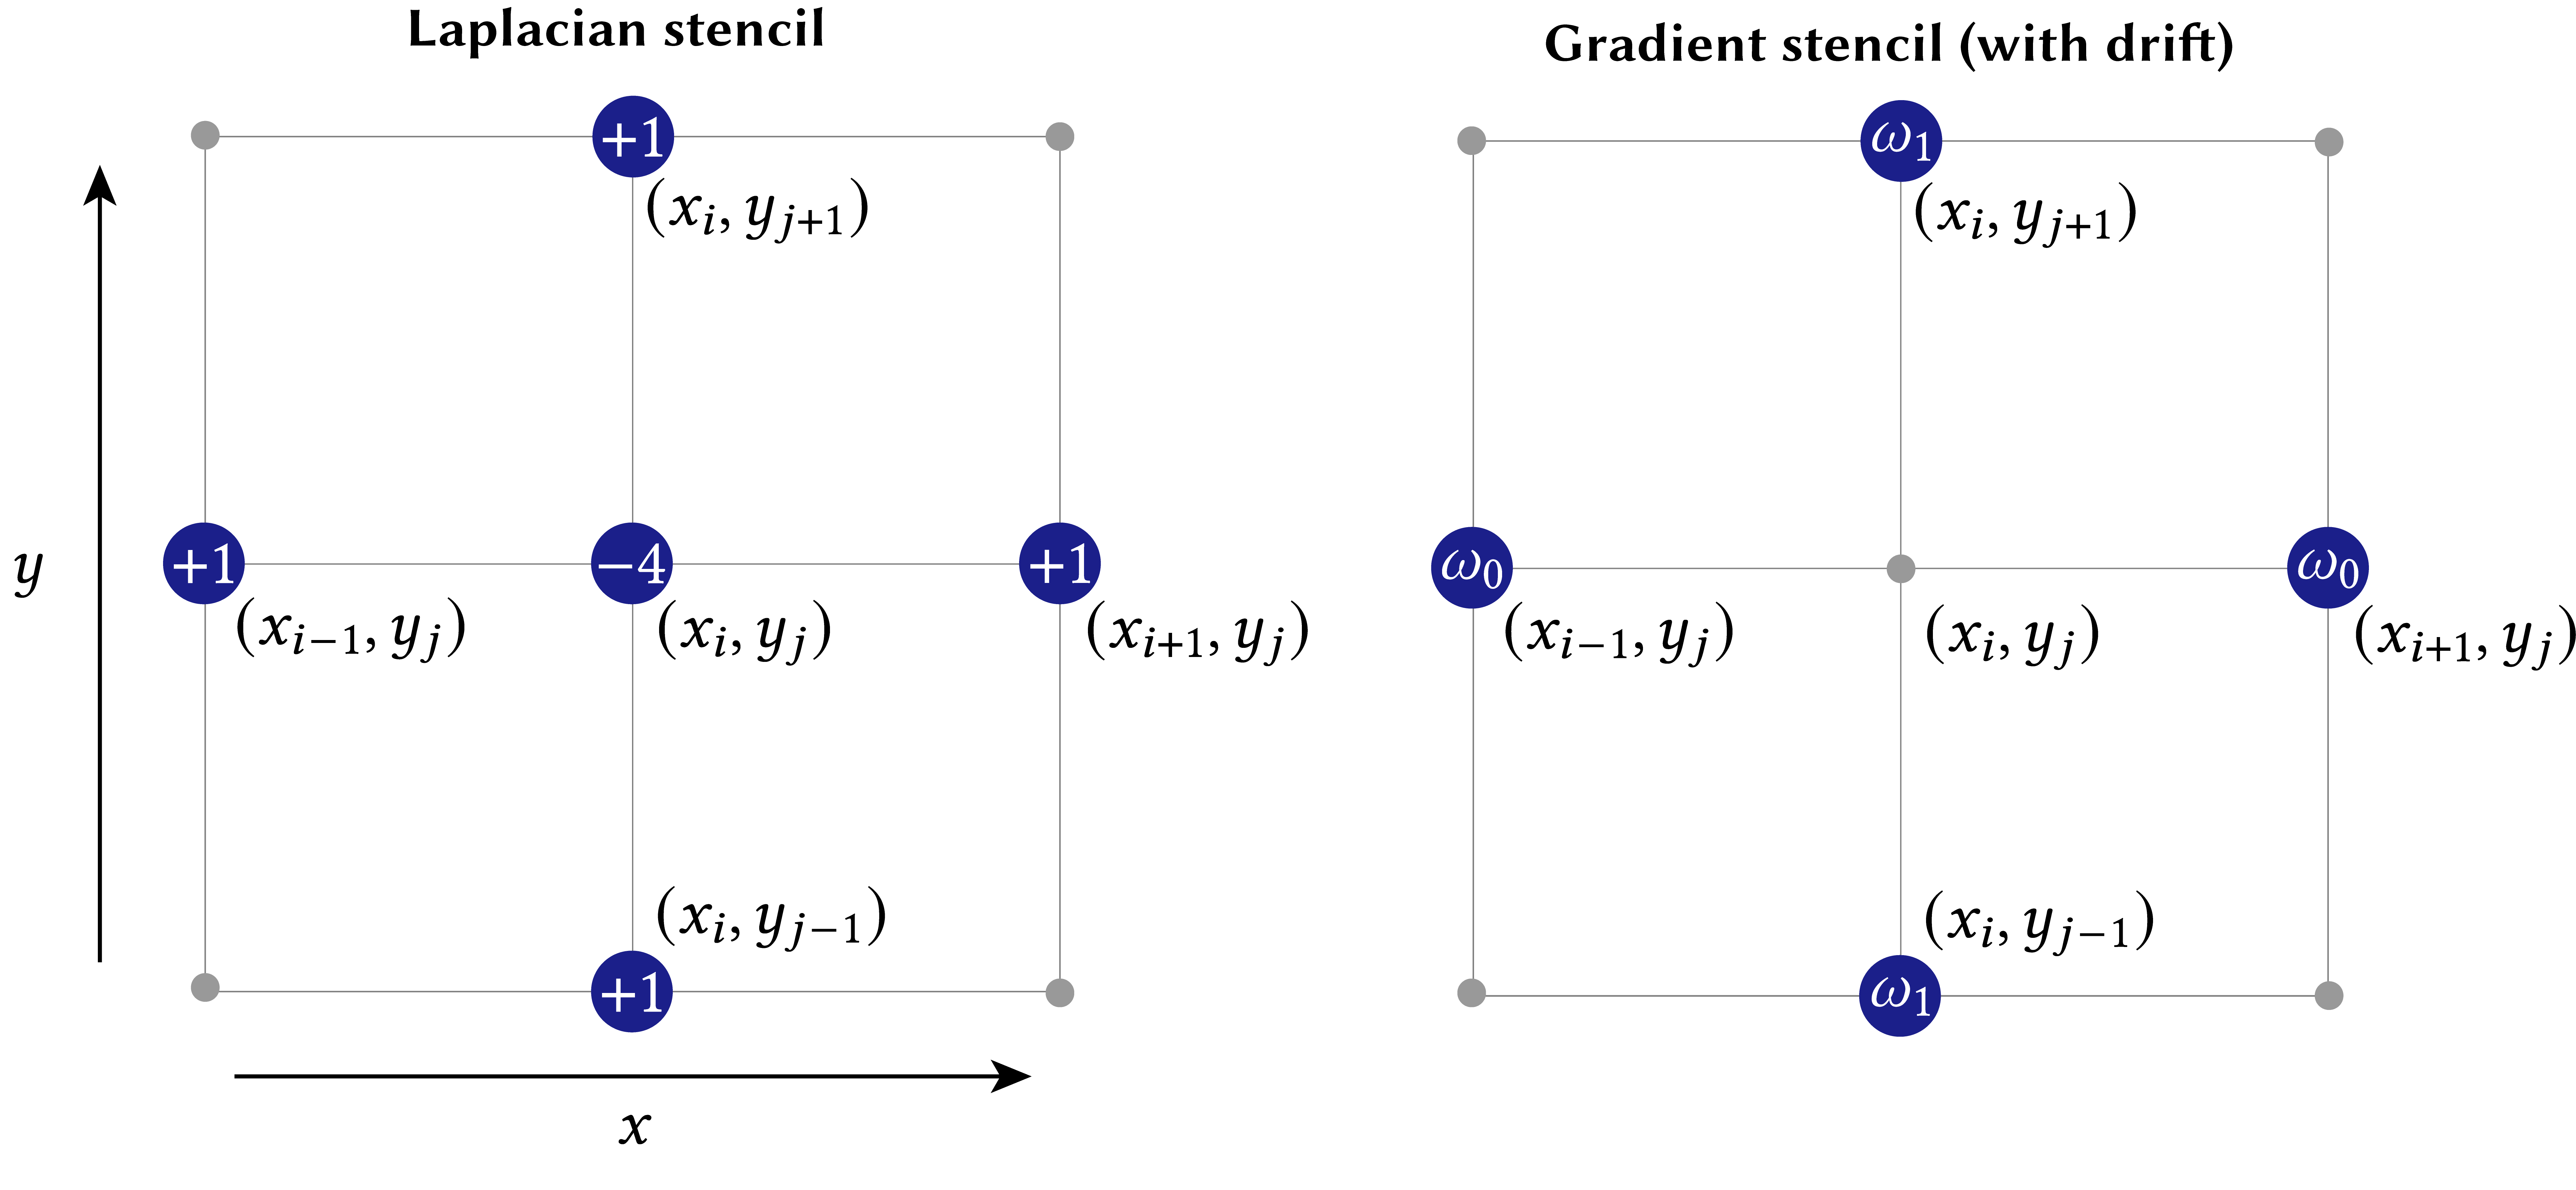

These stencils may no longer be valid near the domain boundary. In this example, we will use a finite-differencing library `findiff` (discussed below) that will automatically adapt the stencils for us.

Finally, the Dirichlet boundary conditions already specify the solution values $u(x_i, y_j)$ on the domain boundary, meaning locations $(x_i,y_j)$ where $i=0$, $i=M-1$, $j=0$, or $j=M-1$. So we additionally have to do a block decomposition of the matrix when we solve the system.

This can all be a bit tedious to implement by hand. Fortunately, there exists the [`findiff`](https://github.com/maroba/findiff) Python module that can take finite differences for us, and solve PDEs with specified Dirichlet boundary conditions. Read the [`findiff` README](https://github.com/maroba/findiff) for an overview of the documentation, including how to solve a PDE with boundary conditions -- in particular, at the very bottom there is an example of setting up a 2D diffusion problem on a regular grid. You may also find the documentation [here](https://findiff.readthedocs.io/en/latest/index.html) helpful.

First run the following cell to install the necessary modules. You may need to comment out the `!pip install` line if you already have the right version of NumPy. **Make sure that the cell below outputs "Using NumPy version: 1.25.0"** (or higher version.) Otherwise, you will get errors about certain functions not being available. **If running the cell requires installling NumPy version 1.25.0, you must also restart the runtime/kernel for the changes to take effect,** after which you should run the below cell again.

In [24]:
# !pip install findiff
# !pip install numpy==1.25.0
import findiff as fd
import numpy as np
import scipy as sp
import random
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing as mp
#import multiprocess as mp # you may need to uncomment this line and comment out the above line if using Jupyter
import tqdm
print("Using NumPy version: %s" %np.__version__)

Using NumPy version: 1.25.0


In [25]:
class HeatDiffusion():

  def __init__(self, nWalks=16, M=32, omega=np.array([1.0,0.0]), size=1.0):

    self.nWalks = nWalks
    self.M = M # number of spatial intervals along each axis
    self.size = size
    self.dx = self.size/(self.M-1)
    # Set up 2D domain = [0,1]^2. Split each axis into M-1 intervals.
    x = np.linspace(0, self.size, M)
    y = np.linspace(0, self.size, M)
    self.X, self.Y = np.meshgrid(x, y, indexing='ij') # the grid point locations (which really represent pixel centers)

    # Assume transport coeff. (drift) is constant.
    self.omega = omega

  def solveFiniteDifference(self):

    L = fd.FinDiff(0, self.dx, 2) + fd.FinDiff(1, self.dx, 2)
    G = self.omega[0]*fd.FinDiff(0, self.dx, 1) + self.omega[1]*fd.FinDiff(1, self.dx, 1)
    diff = L-G
    shape = (self.M, self.M)

    RHS = np.empty(shape)
    for i in range(self.M):
       for j in range(self.M):
          RHS[i][j] = -self.f(self.toX(i, j))
    print(RHS)

    # bc_grid = [[0 for i in range(self.M)] for j in range(self.M)]
    bc = fd.BoundaryConditions(shape)


    # set boundary conditions
    bc[0, :] = [self.g(self.toX(0, i)) for i in range(self.M)]
    bc[-1, :] = [self.g(self.toX(self.M-1, i)) for i in range(self.M)]
    bc[:, 0] = [self.g(self.toX(i,0)) for i in range(self.M)]
    bc[:, -1] = [self.g(self.toX(i, self.M-1)) for i in range(self.M)]

    pde = fd.PDE(diff, RHS, bc)
    u = pde.solve()

    return u

  def solveEulerMaruyamaAtX(self, rng, x, dt=0.01):
    estimate = []
    for i in range(self.nWalks):
      X_k = np.copy(x)
      I = np.array([0.0,0.0])
      # simulate random walk until X_k exits domain
      while(not self.isOutside(X_k)):
        # approximating quadrature using left rectangle rule
        I += self.f(X_k)
        # generate random variable
        W_k = rng.multivariate_normal([0.0,0.0], [[dt,0.0], [0.0, dt]])
        # Simulate using Markov Chain and update X_k, W_k
        X_k = X_k - (self.omega*dt) + W_k

      # clamp and compute a single estimate
      x_prime = self.clampToBoundary(X_k)
      quad_estimate = dt*I
      single_estimate = quad_estimate + self.g(x_prime)

      estimate.append(np.copy(single_estimate))

    # take the average of the estimates
    estimate = np.array(estimate)
    return np.mean(estimate)

  def isOutside(self, x):
    '''
    Return False if the point x is inside the domain, True otherwise.
    '''
    if (x[0]>=0) and (x[0]<=self.size) and (x[1]>=0) and (x[1]<=self.size):
      return False
    return True

  def clampToBoundary(self, x):
    '''
    If outside the domain, returns the closest point x' on the domain boundary.
    '''
    return np.array([min(max(0.0, x[0]),self.size), min(max(0.0, x[1]),self.size)])

  def solveEulerMaruyamaTile(self, tile, iStart, jStart, dt, rng):
    (height, width) = tile.shape
    for i in range(height):
      for j in range(width):
        tile[i,j] = self.solveEulerMaruyamaAtX(rng, self.toX(iStart+i, jStart+j), dt)

    return (tile, iStart, jStart)

  def solveEulerMaruyama(self, dt=0.01):
    '''
    Use Euler-Maruyama to solve at each point in the domain (using the
    finite-difference grid.)
    '''

    nCores = mp.cpu_count()
    tileSize = 16
    nTilesWidth = math.ceil(self.M/tileSize)
    nTilesHeight = math.ceil(self.M/tileSize)
    nTiles = nTilesWidth * nTilesHeight
    rng = np.random.default_rng()
    rngs = rng.spawn(nTiles)
    u = np.empty((self.M, self.M))
    # Use multithreading to accelerate computation.
    args = [(u[i*tileSize: min((i+1)*tileSize, self.M), j*tileSize:min((j+1)*tileSize, self.M)], \
      i*tileSize, j*tileSize, dt, rngs[i*nTilesWidth+j]) \
      for j in range(nTilesWidth) for i in range(nTilesHeight)]
    with mp.Pool(nCores) as p:
      res = p.starmap(self.solveEulerMaruyamaTile, tqdm.tqdm(args, total=nTiles, position=0, leave=True))
    # Combine results.
    for (tile, i, j) in res:
      (height, width) = tile.shape
      u[i:i+height, j:j+width] = tile

    return u

  def toX(self, i, j):
    return np.array([self.dx*i, self.dx*j])

  def g(self, x):
    '''
    Evalulate the boundary data function g(x).
    '''
    ti = int(x[0] * 5.5) % 2 == 0
    tj = int(x[1] * 5.5) % 2 == 0
    return 1.0 if ti==tj else 0.0

  def f(self, x):
    '''
    Evalulate the source term f(x).
    '''
    s = 0.15
    m = np.array([0.5*self.size, 0.5*self.size])
    if (x[0] < m[0]-s) or (x[0] > m[0]+s) or (x[1] < m[1]-s) or (x[1] > m[1]+s):
      return 0.0
    return 30.0

Now run the following cells to see the solutions obtained by using both methods of integration. The first cell displays the input parameters to the heat equation; the following cells display the solutions $u(x)$ computed via PDE and SDE.

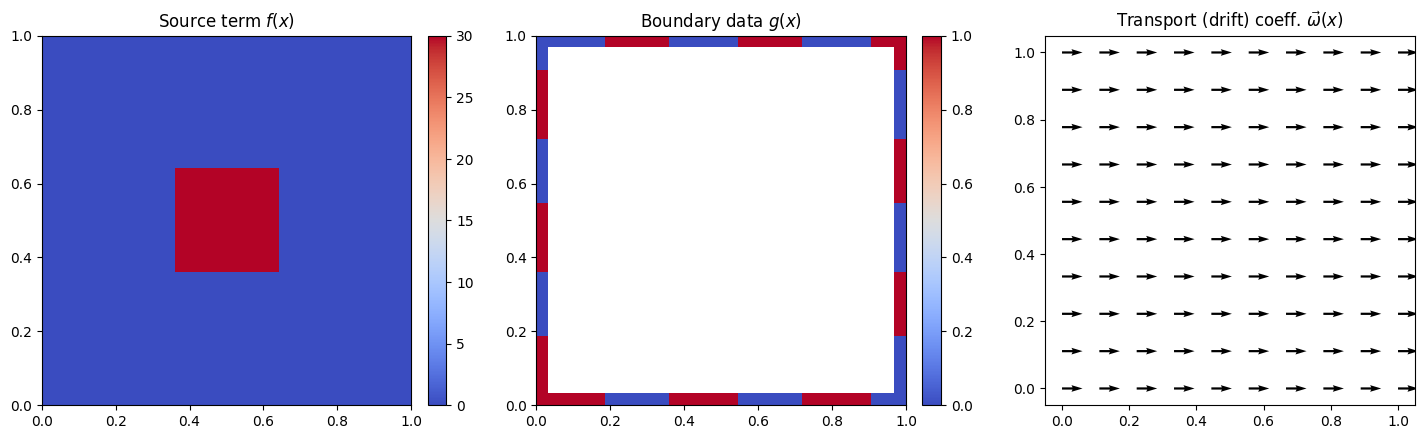

In [26]:
omega = np.array([10.0, 0.0]) # only using constant vector fields in this example
nWalks = 16
size = 1.0
HD = HeatDiffusion(nWalks, M, omega, size)

# First plot f(x), g(x), and omega.
plt.figure()
ax_f = plt.subplot(1, 3, 1) # nrows, ncols, index
im_f = ax_f.imshow([[HD.f([HD.X[i,j], HD.Y[i,j]]) for j in range(M)] for i in range(M)], interpolation='none', cmap=cm.coolwarm,
               origin='lower', extent=[0, size, 0, size])
ax_f.set_title(r'Source term $f(x)$')
plt.colorbar(im_f, ax=ax_f, fraction=0.046, pad=0.04)

ax_g = plt.subplot(1, 3, 2)
h = size*0.02
im_g = ax_g.imshow([[HD.g([HD.X[i,j], HD.Y[i,j]]) if HD.X[i,j]<h or HD.X[i,j]>size-h or HD.Y[i,j]<h or HD.Y[i,j]>size-h else np.inf \
                     for j in range(M)] for i in range(M)], interpolation='none', cmap=cm.coolwarm,
                   origin='lower', extent=[0, size, 0, size])
plt.colorbar(im_g, ax=ax_g, fraction=0.046, pad=0.04)
ax_g.set_title(r'Boundary data $g(x)$')

ax_w = plt.subplot(1, 3, 3)
coarse = np.linspace(0, size, 10)
cX, cY = np.meshgrid(coarse, coarse)
ax_w.quiver(cX, cY, [omega[0] for i in range(10**2)], [omega[1] for i in range(10**2)], angles='xy')
ax_w.set_aspect('equal')
ax_w.set_title(r'Transport (drift) coeff. $\vec{\omega}(x)$')

plt.subplots_adjust(left=0.01, right=2.2)
plt.show()

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


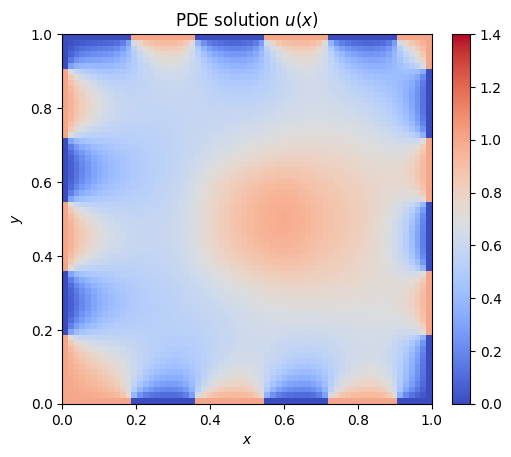

In [27]:
# Run this cell to plot the PDE solution.
M = 64
nWalks = 16
size = 1.0
dt = 1e-3
omega = np.array([10.0, 0.0])

plt.figure()
ax_p = plt.subplot(1, 1, 1)
HD = HeatDiffusion(nWalks, M, omega, size)
u = HD.solveFiniteDifference()
im_p = ax_p.imshow(np.flip(np.transpose(u), axis=0), interpolation='none', cmap=cm.coolwarm, extent=[0, size, 0, size], vmin=0.0, vmax=1.4)
plt.colorbar(im_p, ax=ax_p, fraction=0.046, pad=0.04)
ax_p.set_title(r'PDE solution $u(x)$')
ax_p.set_xlabel(r'$x$')
ax_p.set_ylabel(r'$y$')
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 371.14it/s]


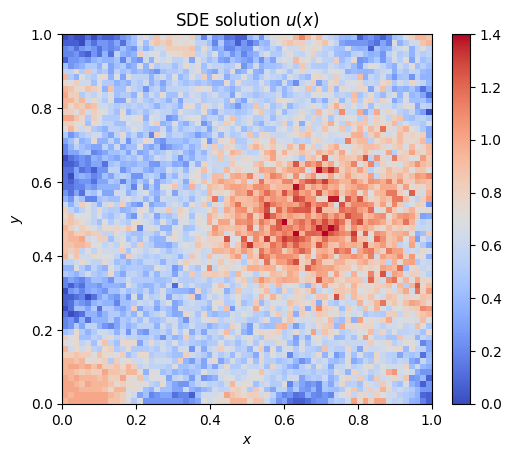

In [28]:
# Run this cell to plot the SDE solution.

# This cell can take a while (~5 minutes) to run, even with multithreading --
# it will be much faster locally than on Colab, however, especially if you have
# more than 2 cores.

# To speed up computation during debugging, decrease `M` or `nWalks`.
# (I wouldn't recomment increasing `dt` over 1e-3, since the accuracy
# significantly degrades at that point.)
M = 64
nWalks = 16
size = 1.0
dt = 1e-3
omega = np.array([10.0, 0.0])

plt.figure()
ax_s = plt.subplot(1, 1, 1)
HD = HeatDiffusion(nWalks, M, omega, size)
u = HD.solveEulerMaruyama(dt)
im_s = ax_s.imshow(np.flip(np.transpose(u), axis=0), interpolation='none', cmap=cm.coolwarm, extent=[0, size, 0, size], vmin=0.0, vmax=1.4)
plt.colorbar(im_s, ax=ax_s, fraction=0.046, pad=0.04)
ax_s.set_title(r'SDE solution $u(x)$')
ax_s.set_xlabel(r'$x$')
ax_s.set_ylabel(r'$y$')
plt.show()

**Note:** The SDE perspective of heat diffusion is not inherently "better" than the PDE perspective, nor vice versa. These examples show a concrete application of the equivalence of the two perspectives, and that the ability to reason about the same phenomenon at different scales can buy us computational benefits in certain scenarios. For instance, benefits to the SDE perspective is that it doesn't require discretization of the domain, yields a "progressive" algorithm (we can gain accuracy simply by simulating more random walks), and can be solved a single point in the domain vs. requiring a global solve.

On the other hand, for some types of problems the amount of random walks needed to obtain an accurate solution is excessive, whereas the corresponding PDE could be solved much more easily via e.g. a system of equations. The computational framework for solving PDEs also often extends more readily to other domains. Fokker-Planck/Kolmogorov equations also do not apply to all types of problems.

Finally, the method we introduced for integrating the SDE is pretty inaccurate and inefficient. There is a particularly efficient and accurate method for solving this SDE called  _walk on spheres_.